In [14]:
import pickle
import os
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

from bpredict import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def run_blackscholes(predictor_factory, output_dir, max_insts):
    # Run the Blackscholes benchmark
    benchmark = '../benchmarks/blackscholes/blackscholes'
    args = (1, '../benchmarks/blackscholes/inputs/small.input', '/dev/null')

    blackscholes_pred = predictor_factory()
    blackscholes_runner = ExternalRunner(blackscholes_pred, benchmark, args=args, maxinsts=max_insts)
    blackscholes_runner.run()

    result = {'predictor': blackscholes_pred, 'runner': blackscholes_runner}
    with open(os.path.join(output_dir, 'blackscholes.pickle'), 'wb') as fp:
        pickle.dump(result, fp)


def run_picosat(predictor_factory, output_dir, max_insts):
    # Run the PicoSAT benchmark
    benchmark = '../benchmarks/picosat/picosat'
    args = ('../benchmarks/picosat/inputs/uuf200-01.cnf', )

    picosat_pred = predictor_factory()
    picosat_runner = ExternalRunner(picosat_pred, benchmark, args=args, maxinsts=max_insts)
    picosat_runner.run()

    result = {'predictor': picosat_pred, 'runner': picosat_runner}
    with open(os.path.join(output_dir, 'picosat.pickle'), 'wb') as fp:
        pickle.dump(result, fp)

def run_sjeng(predictor_factory, output_dir, max_insts):
    # Run the Sjeng benchmark
    benchmark = '../benchmarks/sjeng/sjeng'
    stdin = '\n'.join([
        'sd 8',
        'setboard 3r2k1/3n1ppp/p1p1b3/1nN1p3/2p1P3/Pr2BPP1/1P5P/3RRBK1 b - - 10 20',
        'quit'
    ])

    sjeng_pred = predictor_factory()
    sjeng_runner = ExternalRunner(sjeng_pred, benchmark, stdin=stdin, maxinsts=max_insts)
    sjeng_runner.run()

    result = {'predictor': sjeng_pred, 'runner': sjeng_runner}
    with open(os.path.join(output_dir, 'sjeng.pickle'), 'wb') as fp:
        pickle.dump(result, fp)

def run_sha256(predictor_factory, output_dir, max_insts):
    # Run the SHA256 benchmark
    benchmark = '../benchmarks/sha256sum/sha256sum'
    args = ('../benchmarks/sha256sum/inputs/4M.bin', )

    sha_pred = predictor_factory()
    sha_runner = ExternalRunner(sha_pred, benchmark, args=args, maxinsts=max_insts)
    sha_runner.run()

    result = {'predictor': sha_pred, 'runner': sha_runner}
    with open(os.path.join(output_dir, 'sha.pickle'), 'wb') as fp:
        pickle.dump(result, fp)


def run_benchmarks(predictor_factory, output_dir, max_insts=int(20e6)):
    """Run all benchmarks and save the results in the output_dir directory."""
    if os.path.exists(output_dir):
        raise ValueError('Directory %s already exists' % output_dir)
    os.mkdir(output_dir)
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=2) as pool:
        pool.submit(run_blackscholes, predictor_factory, output_dir, max_insts)
        pool.submit(run_picosat, predictor_factory, output_dir, max_insts)
        pool.submit(run_sjeng, predictor_factory, output_dir, max_insts)
        pool.submit(run_sha256, predictor_factory, output_dir, max_insts)

In [3]:
def predictor_factory():
    return PerceptronPredictor(nperceptrons=256,
                               histlength=36,
                               threshold=48,
                               clip=64,
                               speculative=True,
                               record_trace=RecordSettings.CONDITIONAL)

run_benchmarks(predictor_factory, output_dir='results/global_perceptron', max_insts=int(20e6))

In [7]:
def predictor_factory():
    return LocalPerceptronPredictor(nperceptrons=256,
                                    histlength=36,
                                    threshold=48,
                                    clip=64,
                                    speculative=True,
                                    record_trace=RecordSettings.CONDITIONAL)

run_benchmarks(predictor_factory, output_dir='results/local_perceptron', max_insts=int(20e6))

In [3]:
for i in (9, 18, 27):
    def predictor_factory():
        return CombinedPerceptronPredictor(nperceptrons=256,
                                           global_histlength=36 - i,
                                           local_histlength=i,
                                           threshold=48,
                                           clip=64,
                                           speculative=True,
                                           record_trace=RecordSettings.CONDITIONAL)

    out = 'results/combined_perceptron_G%d_L%d' % (36-i, i)
    run_benchmarks(predictor_factory, output_dir=out, max_insts=int(20e6))

In [3]:
for i in (8, 10, 12):
    def predictor_factory():
        return GSkewPredictor(histlength=i, record_trace=RecordSettings.CONDITIONAL)

    run_benchmarks(predictor_factory, output_dir='results/gskew_%d' % i, max_insts=int(20e6))

In [3]:
for i in (8, 10, 12):
    def predictor_factory():
        return TwoLevelAdaptiveTrainingPredictor(phrtsize=512, histlength=i,
                                                 record_trace=RecordSettings.CONDITIONAL)

    run_benchmarks(predictor_factory, output_dir='results/twolevel_%d' % i, max_insts=int(20e6))

In [74]:
# Combining 2-bit predictor
def predictor_factory():
    p1 = TwoLevelAdaptiveTrainingPredictor(phrtsize=512, histlength=12)
    p2 = GSkewPredictor(histlength=12)
    return Combining2BitPredictor(pred_a=p1, pred_b=p2, ncounters=1024,
                                  record_trace=RecordSettings.CONDITIONAL)

run_benchmarks(predictor_factory, output_dir='results/gskew_twolevel_12', max_insts=int(20e6))

In [6]:
# Multihybrid with a 512 entry two-level predictor with 12 bits of local history and
# two static predictors.
def predictor_factory():
    p1 = TwoLevelAdaptiveTrainingPredictor(phrtsize=512, histlength=12)
    p2 = StaticPredictor(True)
    p3 = StaticPredictor(False)
    return MultiHybridPredictor(predictors=[p1, p2, p3], ncounters=1024,
                                record_trace=RecordSettings.CONDITIONAL)

run_benchmarks(predictor_factory, output_dir='results/multihybrid_twolevel_static_12', max_insts=int(20e6))

In [ ]:
# Multihybrid with a 512 entry two-level predictor with 11 bits of local history and
# two static predictors. This one is smaller than the original 12-bit two-level predictor.
def predictor_factory():
    p1 = TwoLevelAdaptiveTrainingPredictor(phrtsize=512, histlength=11)
    p2 = StaticPredictor(True)
    p3 = StaticPredictor(False)
    return MultiHybridPredictor(predictors=[p1, p2, p3], ncounters=512,
                                record_trace=RecordSettings.CONDITIONAL)

run_benchmarks(predictor_factory, output_dir='results/multihybrid_twolevel_static_11', max_insts=int(20e6))

In [36]:
# Combining two-level with two-bit counter. This should perform similar to the multihybrid with two
# static predictors.
def predictor_factory():
    p1 = TwoLevelAdaptiveTrainingPredictor(phrtsize=512, histlength=12)
    p2 = Local2BitPredictor(ncounters=1024)
    return Combining2BitPredictor(pred_a=p1, pred_b=p2, ncounters=1024,
                                  record_trace=RecordSettings.CONDITIONAL)

run_benchmarks(predictor_factory, output_dir='results/twolevel_twobit_12', max_insts=int(20e6))

In [ ]:
# Get the misprediction rate for predictors and detailled stats
misprediction_rates = dict()
branch_stats = dict()

In [31]:
# Get the number of times a branch was executed, the misprediction rate and the bias
def get_branch_stats(trace):
    taken_hist = dict()
    pred_hist = dict()
    for addr, taken, predicted in trace:
        if addr not in taken_hist:
            taken_hist[addr] = []
            pred_hist[addr] = []
        taken_hist[addr].append(taken)
        pred_hist[addr].append(predicted)
        
    hists = {k: (np.array(taken_hist[k]), np.array(pred_hist[k])) for k in taken_hist}
    stats = [(vt.size, sum(abs(vt - vp)) / vt.size, sum(vt) / vt.size) for (vt, vp) in hists.values()]
    return sorted(stats, reverse=True)



for benchmark in ('blackscholes', 'picosat', 'sjeng', 'sha'):
    misprediction_rates[benchmark] = misprediction_rates.get(benchmark, dict())
    branch_stats[benchmark] = branch_stats.get(benchmark, dict())
    for predtype in ('global_perceptron', 'local_perceptron',
                     'combined_perceptron_G9_L27', 'combined_perceptron_G18_L18', 'combined_perceptron_G27_L9',
                     'gskew_8', 'gskew_10', 'gskew_12',
                     'twolevel_8', 'twolevel_10', 'twolevel_12',
                     'gskew_twolevel_12', 'multihybrid_twolevel_static_12', 'twolevel_twobit_12',
                     'multihybrid_twolevel_static_11'):
        
        if predtype in misprediction_rates[benchmark] and predtype in branch_stats[benchmark]:
            print('Skipping', predtype)
            continue
            
        with open(os.path.join('results', predtype, benchmark + '.pickle'), 'rb') as fp:
            result = pickle.load(fp)
        runner = result['runner']
        predicted = runner.stats[0].find('condPredicted')[0].values[0]
        incorrect = runner.stats[0].find('condIncorrect')[0].values[0]
        misprediction_rates[benchmark][predtype] = incorrect / predicted
        
        pred = result['predictor']
        stats = get_branch_stats(pred.trace)
        branch_stats[benchmark][predtype] = stats

In [18]:
def plot_misprediction_rate(*bps, save=None):
    # set width of bar
    bar_width = 1 / (len(bps) + 1)

    benchmarks = list(misprediction_rates.keys())

    bars = [[misprediction_rates[bm][bp] for bm in benchmarks] for bp in bps]

    # Set position of bar on X axis
    r = [np.arange(len(benchmarks)) + i * bar_width for i in range(len(bps))]
    
    colors = ['#CA3542', '#27647B', '#849FAD', '#AECBC9', '#57575F']

    # Make the plot
    for i in range(len(bps)):
        plt.bar(r[i], bars[i], color=colors[i], width=bar_width, edgecolor='white', label=bps[i])

    # Add description labels
    plt.xlabel('Benchmarks')
    plt.ylabel('Misprediction rate')

    # Add xticks on the middle of the group bars
    off = (len(bps) - 1) * bar_width / 2
    plt.xticks([r + off for r in range(len(benchmarks))], benchmarks)

    # Create legend & Show graphic
    plt.legend()
    
    if save is not None:
        fig = plt.gcf()
        fig.savefig(save)
    
    plt.show()

In [26]:
def plot_bias_scatter(benchmark, predtype, N=10000, save=None):
    mispred_values = [v for _, v, _ in branch_stats[benchmark][predtype][:N]]
    bias_values = [v for _, _, v in branch_stats[benchmark][predtype][:N]]
    s = np.array([v for v, _, _ in branch_stats[benchmark][predtype][:N]])

    plt.scatter(bias_values, mispred_values, s=2*np.sqrt(s), edgecolor='black', color='#CA3542')
    plt.xlabel('Bias')
    plt.ylabel('Misprediction rate')
    plt.plot([0, 0.5], [0, 0.5], color='#27647B', linewidth=5)
    plt.plot([0.5, 1], [0.5, 0], color='#27647B', linewidth=5)
    
    if save is not None:
        fig = plt.gcf()
        fig.savefig(save)
    
    plt.show()

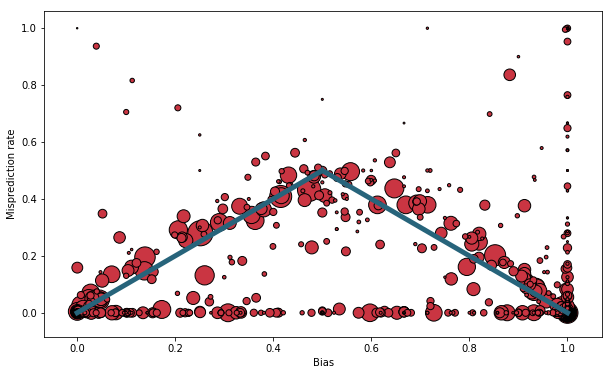

In [27]:
plot_bias_scatter('picosat', 'twolevel_12', save='plots/scatter_twolevel_12.pdf')

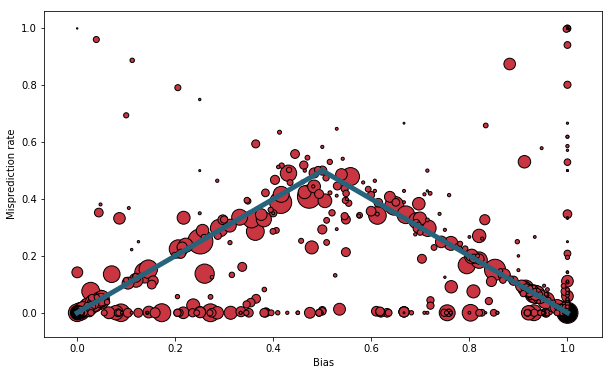

In [32]:
plot_bias_scatter('picosat', 'multihybrid_twolevel_static_11',
                  save='plots/scatter_multihybrid_twolevel_static_11.pdf')

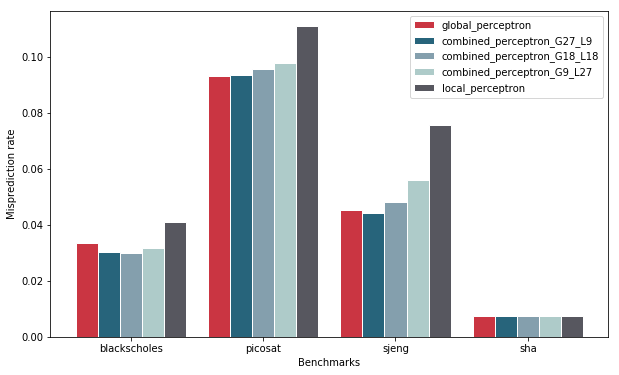

In [19]:
plot_misprediction_rate('global_perceptron',
                        'combined_perceptron_G27_L9',
                        'combined_perceptron_G18_L18',
                        'combined_perceptron_G9_L27',
                        'local_perceptron', save='plots/perceptrons.pdf')

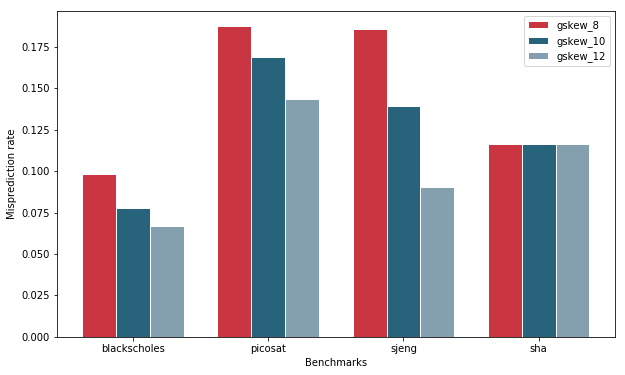

In [90]:
plot_misprediction_rate('gskew_8', 'gskew_10', 'gskew_12')

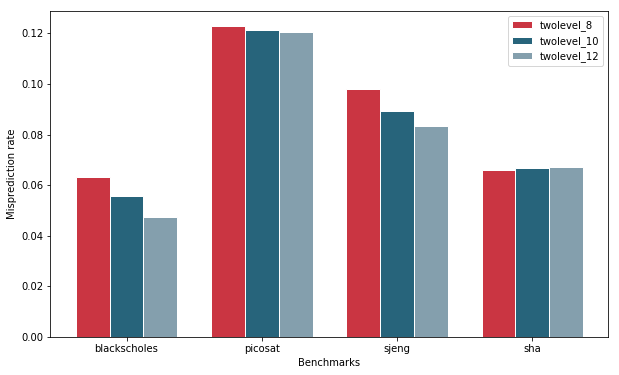

In [91]:
plot_misprediction_rate('twolevel_8', 'twolevel_10', 'twolevel_12')

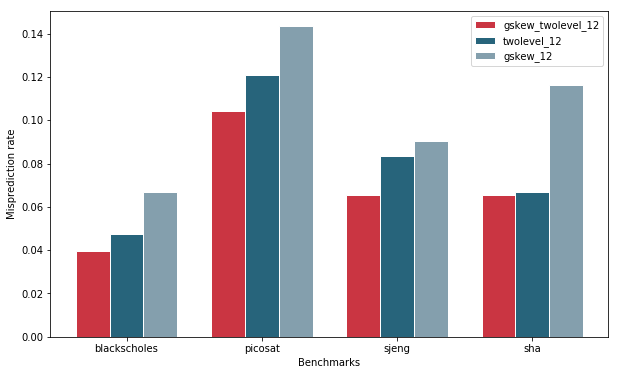

In [92]:
plot_misprediction_rate('gskew_twolevel_12', 'twolevel_12', 'gskew_12')

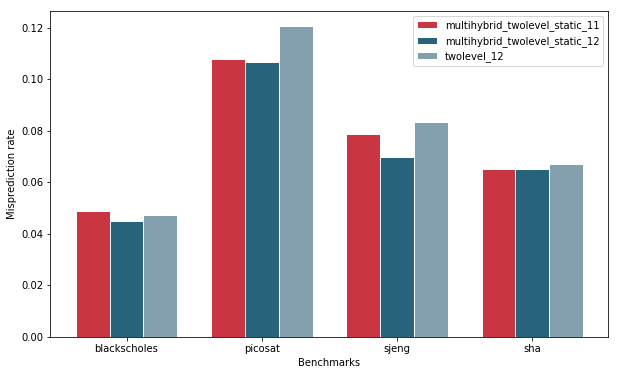

In [34]:
plot_misprediction_rate('multihybrid_twolevel_static_11', 'multihybrid_twolevel_static_12', 'twolevel_12',
                        save='plots/multihybrid_mispred_rate.pdf')